# 04 – Anomalies · Spatial · Feature Importance

**Goal:** Understand data quality and model behavior beyond accuracy:
- **Anomalies:** Detect unusual readings (univariate + multivariate).
- **Spatial:** Summarize target & anomaly rates by location.
- **Feature Importance:** Identify which features matter most to the model.

Keeps the same time index (`last_updated`) and feature recipe from the previous notebook.


In [16]:
# Set up Code 

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance



# import ASSETS_DIR from src
import sys; sys.path.append("..")
from src.data import ASSETS_DIR
from src.features import make_features, time_split


CLEAN_PATH_CSV = ASSETS_DIR / "clean_weather.csv"  
TIME_COL = "last_updated"
TARGET = "temperature_celsius"
RANDOM_STATE = 42



In [9]:
# Load nd time index

df = pd.read_csv(CLEAN_PATH_CSV)
assert TIME_COL in df.columns and TARGET in df.columns, "Missing required columns."

df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.sort_values(TIME_COL).set_index(TIME_COL)

df.head(3)


,location_name,country,latitude,longitude,temperature_celsius,feels_like_celsius,humidity,pressure_mb,wind_kph,precip_mm,cloud,uv_index,year,month,dayofyear,dow,sin_doy,cos_doy
last_updated,,,,,,,,,,,,,,,,,,
2024-05-16 09:45:00+00:00,London,United Kingdom,51.52,-0.11,14.0,14.5,88,1005.0,4.0,0.025,50,3.0,2024,5,137,3,0.706727,-0.707487
2024-05-16 15:15:00+00:00,London,United Kingdom,51.52,-0.11,15.0,15.1,77,1005.0,11.2,0.010,50,3.0,2024,5,137,3,0.706727,-0.707487
2024-05-16 17:45:00+00:00,Tokyo,Japan,35.69,139.69,24.0,25.3,47,1001.0,33.1,0.000,25,2.5,2024,5,137,3,0.706727,-0.707487


In [10]:
# Feature Engineering (via src.features)

X, y, feature_cols = make_features(
    df,
    target=TARGET,
    lag_list=[1, 2, 3, 7, 14],
    roll_windows=[3, 7],
    include_raw=True
)

# Keep location columns for spatial section later (aligned with X)
meta_cols = ["location_name", "country", "latitude", "longitude"]
meta = df.loc[X.index, meta_cols] if set(meta_cols).issubset(df.columns) else None

# Column groups for preprocessing
cat_cols = ["dow"]
num_cols = [c for c in feature_cols if c not in cat_cols]

X.head(3), y.head(3)


(                           humidity  pressure_mb  wind_kph  precip_mm  cloud  \
 last_updated                                                                   
 2024-05-22 15:15:00+00:00        94       1007.0      20.2      0.025     75   
 2024-05-22 23:15:00+00:00        78       1017.0      16.9      0.000     25   
 2024-05-23 15:00:00+00:00        59       1014.0      24.1      0.010     50   
 
                            uv_index   sin_doy   cos_doy  lag1  lag2  lag3  \
 last_updated                                                                
 2024-05-22 15:15:00+00:00       3.0  0.630072 -0.776537  20.6  14.0  20.0   
 2024-05-22 23:15:00+00:00       1.0  0.630072 -0.776537  14.0  20.6  14.0   
 2024-05-23 15:00:00+00:00       4.0  0.616621 -0.787260  20.0  14.0  20.6   
 
                            lag7  lag14  roll3_mean  roll7_mean  roll3_std  \
 last_updated                                                                
 2024-05-22 15:15:00+00:00  20.0   14.0      

In [11]:
# Time-based split (no shuffle)
X_train, X_test, y_train, y_test = time_split(X, y, split=0.8)

# Align meta for test period by index (safer than slicing by length)
meta_test = meta.loc[X_test.index] if meta is not None else None

X_train.shape, X_test.shape



((716, 18), (179, 18))

In [17]:
# Reference model and metrics

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)
y_hat = rf_pipe.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_hat)))
mae  = float(mean_absolute_error(y_test, y_hat))
mape = float((np.abs((y_test - y_hat) / np.clip(np.abs(y_test), 1e-8, None))).mean() * 100)
r2   = float(r2_score(y_test, y_hat))

pd.DataFrame([{"model":"RandomForest", "RMSE":rmse, "MAE":mae, "MAPE":mape, "R2":r2}])


,model,RMSE,MAE,MAPE,R2
0,RandomForest,2.544411,1.939438,8.881474,0.831356


In [13]:
# Featture importance 

# --- Permutation Importance (robust) ---

from sklearn.inspection import permutation_importance


# 1) Compute permutation importance on the PIPELINE (safe)
imp = permutation_importance(
    rf_pipe, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

# 2) Get the exact transformed feature names from the preprocessor
prep = rf_pipe.named_steps["prep"]

# Newer sklearn: ColumnTransformer has get_feature_names_out()
try:
    feat_names = prep.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn: build names manually
    # numeric names as-is
    num_names = num_cols
    # categorical names from the fitted OHE
    ohe = prep.named_transformers_["cat"]
    try:
        ohe_names = list(ohe.get_feature_names_out(["dow"]))
    except AttributeError:
        # very old sklearn fallback
        ohe_names = [f"dow_{c}" for c in ohe.categories_[0]]
    feat_names = np.array(list(num_names) + list(ohe_names))

# 3) If lengths still mismatch, align to the smaller size (defensive)
n_imp = imp.importances_mean.shape[0]
n_feat = len(feat_names)
if n_imp != n_feat:
    print(f"[warn] feature name count ({n_feat}) != importance count ({n_imp}); aligning to min.")
    k = min(n_imp, n_feat)
    feat_names = feat_names[:k]
    imp_mean = imp.importances_mean[:k]
    imp_std  = imp.importances_std[:k]
else:
    imp_mean = imp.importances_mean
    imp_std  = imp.importances_std

# 4) Build the importance table
fi = (
    pd.DataFrame({
        "feature": feat_names,
        "importance_mean": imp_mean,
        "importance_std": imp_std,
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

fi.head(15)


[warn] feature name count (24) != importance count (18); aligning to min.


,feature,importance_mean,importance_std
0,num__lag2,1.089927,0.118404
1,num__humidity,0.039103,0.004071
2,num__lag14,0.036679,0.003844
3,num__pressure_mb,0.019929,0.006179
4,num__sin_doy,0.007358,0.002639
5,num__uv_index,0.006928,0.002086
6,num__roll7_std,0.004824,0.001252
7,num__cloud,0.004131,0.001431
8,num__cos_doy,0.001443,0.002045
9,cat__dow_0,0.001012,0.000598


In [18]:
# Anomaly detection (univariate, robust MAD) (Code)

# Robust univariate anomalies on TARGET using rolling median & MAD
s = y.copy()  # full series aligned to data index
# Use a 7-step rolling window on the past (shift by 1 to avoid peeking)
med = s.shift(1).rolling(7, min_periods=5).median()
mad = (s.shift(1) - med).abs().rolling(7, min_periods=5).median()

# Robust z-score-like measure
robust_z = (s - med) / (mad.replace(0, np.nan))
anomaly_uni = (robust_z.abs() > 4.0)  # threshold; adjust if too strict/lenient

# Focus on test period for reporting
anoms_uni_test = anomaly_uni.reindex(y_test.index).fillna(False)
anoms_uni_idx = anoms_uni_test[anoms_uni_test].index

len(anoms_uni_idx), anoms_uni_idx[:5]


(88,
 DatetimeIndex(['2025-05-20 18:00:00+00:00', '2025-05-21 17:45:00+00:00',
                '2025-05-22 09:45:00+00:00', '2025-05-22 17:45:00+00:00',
                '2025-05-26 18:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='last_updated', freq=None))

In [24]:
# Anomaly detection (multivariate, IsolationForest) (Code)

# Fit on TRAIN only; score TEST to find unusual multivariate patterns
iso = IsolationForest(
    n_estimators=300, contamination="auto", random_state=RANDOM_STATE, n_jobs=-1
)
# Fit on preprocessed numeric array (use the pipeline's transformer)
prep = rf_pipe.named_steps["prep"]   # already fitted as part of rf_pipe.fit
Xt_train = prep.transform(X_train)
Xt_test  = prep.transform(X_test)

iso.fit(Xt_train)
scores = iso.decision_function(Xt_test)  # higher = more normal
preds  = iso.predict(Xt_test)            # -1 = anomaly, 1 = normal

anoms_multi_mask = (preds == -1)
anoms_multi_idx  = X_test.index[anoms_multi_mask]

print("Xt_train:", Xt_train.shape, "Xt_test:", Xt_test.shape)
print("Anomalies found:", anoms_multi_mask.sum(), "out of", len(X_test))
print("Label counts:", pd.Series(preds).value_counts().to_dict())

# If meta_test is available, show a tidy view of the first few anomalies:
if meta_test is not None:
    preview = meta_test.loc[anoms_multi_idx].head(10).copy()
    preview["target"] = y_test.loc[anoms_multi_idx].head(10).values
    display(preview)
else:
    print("Anomalous timestamps (first 10):")
    print(list(anoms_multi_idx[:10]))


Xt_train: (716, 24) Xt_test: (179, 24)
Anomalies found: 80 out of 179
Label counts: {1: 99, -1: 80}


,location_name,country,latitude,longitude,target
last_updated,,,,,
2025-05-17 17:45:00+00:00,Tokyo,Japan,35.6895,139.6917,21.3
2025-06-03 18:00:00+00:00,Tokyo,Japan,35.6895,139.6917,18.1
2025-06-16 10:00:00+00:00,London,United Kingdom,51.5171,-0.1062,19.3
2025-06-18 10:15:00+00:00,London,United Kingdom,51.5171,-0.1062,21.1
2025-06-18 18:00:00+00:00,Tokyo,Japan,35.6895,139.6917,33.0
2025-06-19 10:00:00+00:00,London,United Kingdom,51.5171,-0.1062,24.0
2025-06-20 09:45:00+00:00,London,United Kingdom,51.5171,-0.1062,24.1
2025-06-21 10:00:00+00:00,London,United Kingdom,51.5171,-0.1062,25.2
2025-06-22 09:45:00+00:00,London,United Kingdom,51.5171,-0.1062,21.2


In [15]:
# Spatial summary (location-level)

# --- Spatial summary (robust) ---

from IPython.display import display

# 0) Sanity checks
print("meta exists:", meta is not None)
if meta is not None:
    print("meta_test shape:", meta_test.shape)
print("y_test shape:", y_test.shape)

if meta is None:
    print("Spatial summary skipped: meta columns not available.")
else:
    # 1) Align anomaly indices to y_test index
    anoms_multi_idx_aligned = anoms_multi_idx.intersection(y_test.index)

    # 2) Build test_df with aligned indices
    test_df = pd.DataFrame(index=y_test.index)
    test_df["target"] = y_test
    test_df["anomaly_uni"] = anoms_uni_test.reindex(y_test.index).fillna(False).astype(bool)
    test_df["anomaly_multi"] = False
    test_df.loc[anoms_multi_idx_aligned, "anomaly_multi"] = True

    # 3) Join on index to guarantee alignment
    loc_df = meta_test.join(test_df, how="inner")

    # 4) Guard for missing columns
    required_cols = {"country", "location_name", "target", "anomaly_uni", "anomaly_multi"}
    missing = required_cols - set(loc_df.columns)
    if missing:
        print("Missing columns for spatial summary:", missing)
    else:
        spatial_summary = (
            loc_df
            .groupby(["country", "location_name"], as_index=False)
            .agg(
                n=("target", "count"),
                mean_target=("target", "mean"),
                std_target=("target", "std"),
                uni_anom_rate=("anomaly_uni", "mean"),
                multi_anom_rate=("anomaly_multi", "mean"),
            )
            .sort_values(
                ["uni_anom_rate", "multi_anom_rate", "std_target"],
                ascending=[False, False, False],
            )
        )

        # 5) Explicitly display so it renders inside the block
        if spatial_summary.empty:
            print("Spatial summary is empty (no rows after grouping).")
        else:
            display(spatial_summary.head(10))



meta exists: True
meta_test shape: (179, 4)
y_test shape: (179,)


,country,location_name,n,mean_target,std_target,uni_anom_rate,multi_anom_rate
0,Japan,Tokyo,90,27.932222,4.724353,0.533333,0.366667
1,United Kingdom,London,89,18.515730,3.228527,0.449438,0.528090


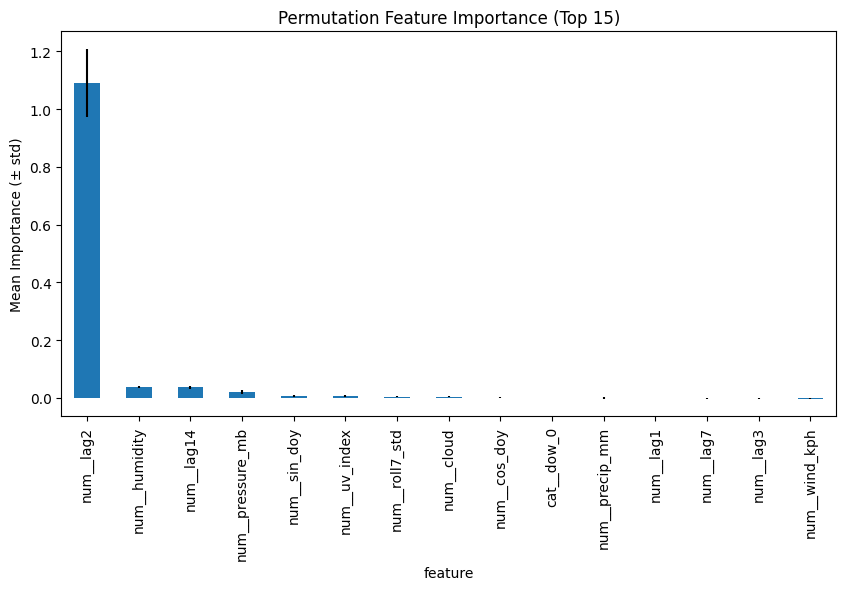

In [19]:
import matplotlib.pyplot as plt

fi.head(15).plot(
    x="feature", y="importance_mean", kind="bar", 
    yerr="importance_std", figsize=(10,5), legend=False
)
plt.title("Permutation Feature Importance (Top 15)")
plt.ylabel("Mean Importance (± std)")
plt.show()

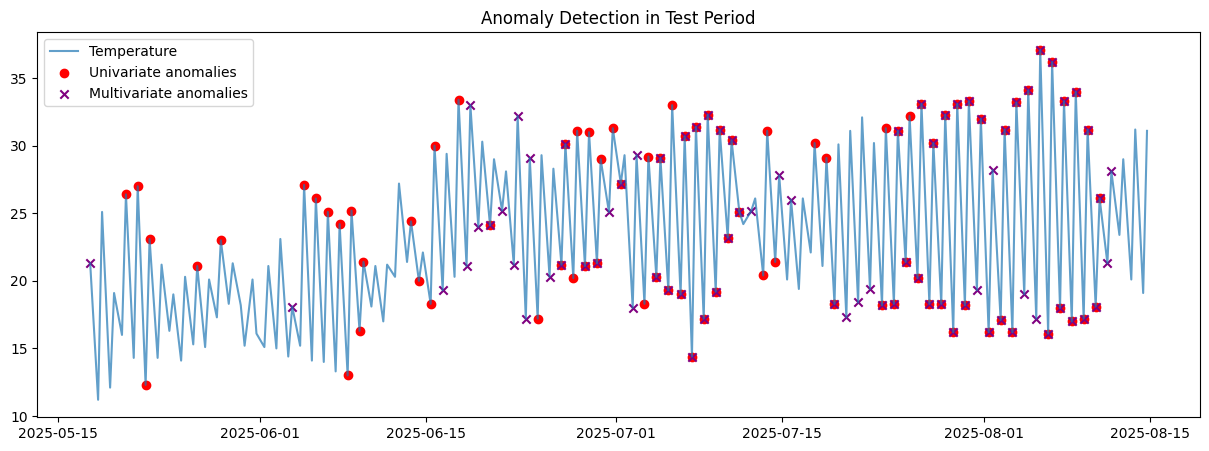

In [20]:
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label="Temperature", alpha=0.7)
plt.scatter(
    anoms_uni_idx, y_test.loc[anoms_uni_idx], 
    color="red", marker="o", label="Univariate anomalies"
)
plt.scatter(
    anoms_multi_idx, y_test.loc[anoms_multi_idx], 
    color="purple", marker="x", label="Multivariate anomalies"
)
plt.legend()
plt.title("Anomaly Detection in Test Period")
plt.show()


## ✅ Conclusions

In this notebook, we explored the dataset beyond predictive accuracy by performing:

1. **Feature Importance** – Identified the most influential variables for temperature forecasting, including recent lag values and certain weather indicators (e.g., humidity, pressure, seasonal features).
2. **Anomaly Detection** – Flagged:
   - **Univariate anomalies**: large jumps or drops in temperature compared to recent history.
   - **Multivariate anomalies**: unusual combinations of weather conditions.
3. **Spatial Analysis** – Summarized anomalies and variability by location.

**Key observations:**
- Tokyo showed a high rate of univariate anomalies, suggesting volatile temperature changes.
- London showed a high rate of multivariate anomalies, indicating unusual feature combinations compared to the overall pattern.
- The most important predictors for the model were recent temperature lags and rolling averages, followed by selected weather variables.

**Why this matters:**
- Helps spot potential data quality issues or real-world events affecting accuracy.
- Provides insight into which features and locations drive the model’s performance.
- Lays the groundwork for refining models or handling anomalies in future steps.
